# Run pTFCE on simulated data in Python and R

The R package `pTFCE` carries assumptions about the nature of the data (smoothness, gaussianity, etc) so it's not possible to take an MEG dSPM source estimate (which will violate those assumptions) and expect the R package to give a reasonable answer. So to compare our Python implementation with the R package, we'll start by simulating some fake data that *does* conform to the assumptions of the method (viz, gaussian random field theory).

In [1]:
%load_ext rpy2.ipython

In [2]:
from functools import reduce

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
from FyeldGenerator import generate_field
from mne.stats import combine_adjacency
from nilearn.plotting import plot_glass_brain
from rpy2.robjects.vectors import IntVector
from scipy.stats import multivariate_normal, norm, zscore

from ptfce import plot_null_distr, ptfce, timer

# configuration variables
rng = np.random.default_rng(seed=15485863)  # the one millionth prime
n_iter = 30
shape = (64, 64, 16)
assert len(shape) == 3, 'need 3 dimensions for R code to work'
r_shape = IntVector(shape)  # for passing to R cell

First we define a helper function to generate (possibly multiple iterations of) some GRF background noise of a given size.

In [3]:
def make_grf_noise(size, n_iter):
    """Simulate gaussian random fields."""
    result = np.empty((n_iter,) + tuple(size))

    def stat(size):
        return rng.normal(size=size) + 1j * rng.normal(size=size)

    def power(freq):
        with np.testing.suppress_warnings() as sup:
            sup.filter(RuntimeWarning,
                       'divide by zero encountered in true_divide')
            return 1 / freq

    for _iter in range(n_iter):
        result[_iter] = generate_field(
            statistic=stat, power_spectrum=power, shape=size)
    return result

Next we generate a noisy signal and z-score it (as is typically done with MRI data).

In [4]:
# make fake signal (mixed with noise)
background = make_grf_noise(shape, 1)[0]
indices = np.array(list(np.ndindex(shape))) - np.array(shape) // 2
mean = (0,) * len(shape)
signal = multivariate_normal(mean=mean).pdf(indices / 5).reshape(shape)
data = background + 1.5 * signal
data = zscore(data, axis=None)

### Run pTFCE in R

Running pTFCE in R requires the data to be in Nifti format, but `rpy2` can't pass Nifti format between Python and R, so we'll pass in the `data` array, and pass back the enhanced data after extracting it from the Nifti container.

In [5]:
%%R -i data -i r_shape -o enhanced_img_R -o pvals_R -o neglogp_R

library(oro.nifti)
library(pTFCE)

# avoid non-finite values in R
data[data > 37] <- 37

img <- nifti(data, dim=r_shape, datatype=16)
mask <- nifti(array(1, dim=r_shape))

result <- ptfce(img, mask)
pvals_R <- result$p@.Data
neglogp_R <- result$logp@.Data
enhanced_img_R <- result$Z@.Data

R[write to console]: oro.nifti 0.11.0



* Estimating smoothness based on the data...
  |======================================================================| 100%
* Performing pTFCE...
  |======================================================================| 100%


### Run pTFCE in Python

For the Python implementation, we pre-compute some noise samples (and z-score them). We also need an adjacency matrix (passing `*shape` will create a regular lattice adjacency of the right size for our data).

In [6]:
# make several iterations of just noise
noise = make_grf_noise(shape, n_iter)
_noise = zscore(noise.reshape(n_iter, -1), axis=-1)
# make adjacency matrix
adjacency = combine_adjacency(*shape)
# calc max cluster size
max_cluster_size = reduce(np.multiply, shape)

Now we'll run pTFCE using our Python implementation:

In [7]:
# compute pTFCE
with timer('running pTFCE'):
    (_ptfce,
     all_thresholds,
     unaggregated_probs,
     source_activation_density_func,
     all_noise_cluster_sizes,
     cluster_size_density_func,
     all_data_clusters_by_thresh,
     all_data_cluster_sizes_by_thresh
     ) = ptfce(data.ravel(), adjacency, _noise,
               max_cluster_size=max_cluster_size, seed=rng)

# convert back to original shape
pvals = _ptfce.reshape(shape)
# convert probabilities (p-values) into Z-scores
enhanced_img = norm.isf(pvals)
# also compute -log(p)
neglogp = -1 * np.log(pvals)

running pTFCE: calculating source activation prior: 0.0280 sec.


running noise simulations:   0%|          | 0/30 [00:00<?, ?simulation/s]

finding clusters at each threshold:   0%|          | 0/100 [00:00<?, ?threshold/s]

finding clusters at each threshold:   0%|          | 0/100 [00:00<?, ?threshold/s]

finding clusters at each threshold:   0%|          | 0/100 [00:00<?, ?threshold/s]

finding clusters at each threshold:   0%|          | 0/100 [00:00<?, ?threshold/s]

finding clusters at each threshold:   0%|          | 0/100 [00:00<?, ?threshold/s]

finding clusters at each threshold:   0%|          | 0/100 [00:00<?, ?threshold/s]

finding clusters at each threshold:   0%|          | 0/100 [00:00<?, ?threshold/s]

finding clusters at each threshold:   0%|          | 0/100 [00:00<?, ?threshold/s]

finding clusters at each threshold:   0%|          | 0/100 [00:00<?, ?threshold/s]

finding clusters at each threshold:   0%|          | 0/100 [00:00<?, ?threshold/s]

finding clusters at each threshold:   0%|          | 0/100 [00:00<?, ?threshold/s]

finding clusters at each threshold:   0%|          | 0/100 [00:00<?, ?threshold/s]

finding clusters at each threshold:   0%|          | 0/100 [00:00<?, ?threshold/s]

finding clusters at each threshold:   0%|          | 0/100 [00:00<?, ?threshold/s]

finding clusters at each threshold:   0%|          | 0/100 [00:00<?, ?threshold/s]

finding clusters at each threshold:   0%|          | 0/100 [00:00<?, ?threshold/s]

finding clusters at each threshold:   0%|          | 0/100 [00:00<?, ?threshold/s]

finding clusters at each threshold:   0%|          | 0/100 [00:00<?, ?threshold/s]

finding clusters at each threshold:   0%|          | 0/100 [00:00<?, ?threshold/s]

finding clusters at each threshold:   0%|          | 0/100 [00:00<?, ?threshold/s]

finding clusters at each threshold:   0%|          | 0/100 [00:00<?, ?threshold/s]

finding clusters at each threshold:   0%|          | 0/100 [00:00<?, ?threshold/s]

finding clusters at each threshold:   0%|          | 0/100 [00:00<?, ?threshold/s]

finding clusters at each threshold:   0%|          | 0/100 [00:00<?, ?threshold/s]

finding clusters at each threshold:   0%|          | 0/100 [00:00<?, ?threshold/s]

finding clusters at each threshold:   0%|          | 0/100 [00:00<?, ?threshold/s]

finding clusters at each threshold:   0%|          | 0/100 [00:00<?, ?threshold/s]

finding clusters at each threshold:   0%|          | 0/100 [00:00<?, ?threshold/s]

finding clusters at each threshold:   0%|          | 0/100 [00:00<?, ?threshold/s]

finding clusters at each threshold:   0%|          | 0/100 [00:00<?, ?threshold/s]

calculating cluster size distribution from noise: 0.1195 sec.


finding clusters in real data:   0%|          | 0/100 [00:00<?, ?threshold/s]

aggregating and adjusting probabilities: 0.0514 sec.
1361.5436 sec.


### Compare results

Let's make a reusable plotting function

In [8]:
def make_plots(**kwargs):
    titles = list(kwargs)
    arrays = list(kwargs.values())
    # precompute color limits
    clim = (min(arr.min() for arr in arrays),
            max(arr.max() for arr in arrays))
    # init figure
    fig, axs = plt.subplots(1, len(kwargs), sharex=True, sharey=True)
    fig.set_size_inches(15, 4)
    # show a slice through the middle of the volume, where the "signal" was
    slice_idx = arrays[0].shape[-1] // 2
    # plot images
    for ax, title, array in zip(axs, titles, arrays):
        ax.imshow(array[..., slice_idx], cmap='Greys', clim=clim)
        ax.set(title=title)
    # garnish
    fig.supxlabel('voxel index')
    fig.supylabel('voxel index')
    return fig   

Here are the data values (z-scores)

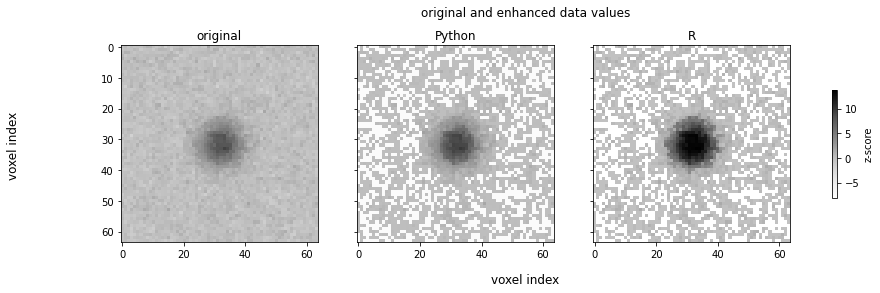

In [9]:
fig = make_plots(original=data, Python=enhanced_img, R=enhanced_img_R)
fig.suptitle('original and enhanced data values')
_ = fig.colorbar(fig.axes[0].images[0], ax=fig.axes, shrink=0.5, label='z-score')

Let's also plot the p-values and $-log(p)$ values to get a sense of the relative power of the two implementations

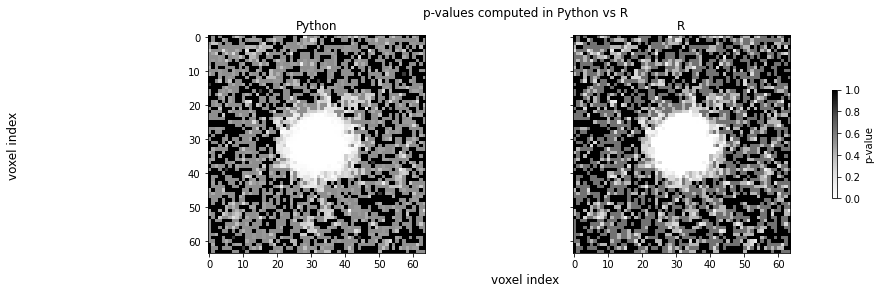

In [10]:
fig = make_plots(Python=pvals, R=pvals_R)
fig.suptitle('p-values computed in Python vs R')
_ = fig.colorbar(fig.axes[0].images[0], ax=fig.axes, shrink=0.5, label='p-value')

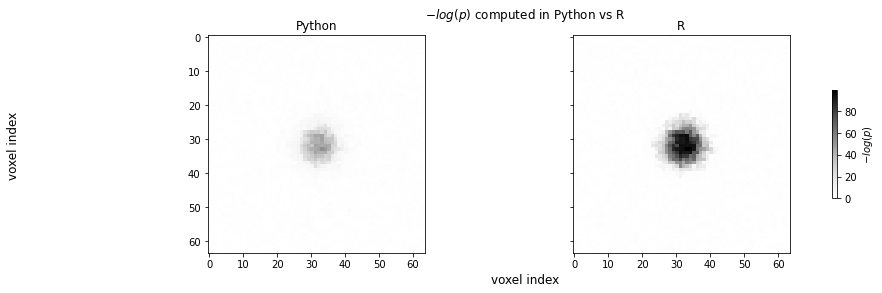

In [11]:
fig = make_plots(Python=neglogp, R=neglogp_R)
fig.suptitle('$-log(p)$ computed in Python vs R')
_ = fig.colorbar(fig.axes[0].images[0], ax=fig.axes, shrink=0.5, label='$-log(p)$')

Let's see how far off from the analytic distribution our estimates are:

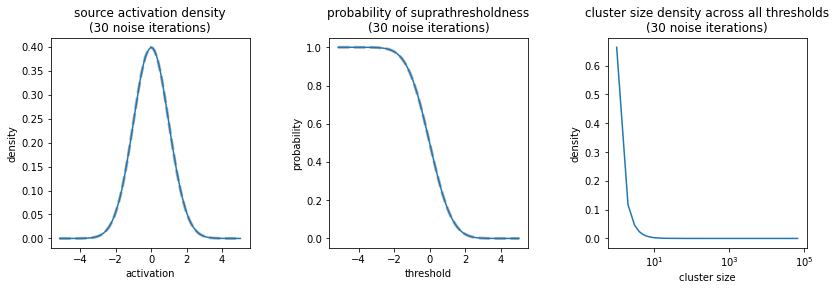

In [12]:
fig = plot_null_distr(
    _noise, n_iter, source_activation_density_func, cluster_size_density_func,
    all_noise_cluster_sizes, compare='normal')

Finally let's plot the Python vs R data values, to see whether there's a systematic shift (indicating a problem with our implementation) or something less linear (likely arising from the Python implementation's *estimation* of distributions based on noise simulations, versus the R implementation's use of *analytic* distributions).

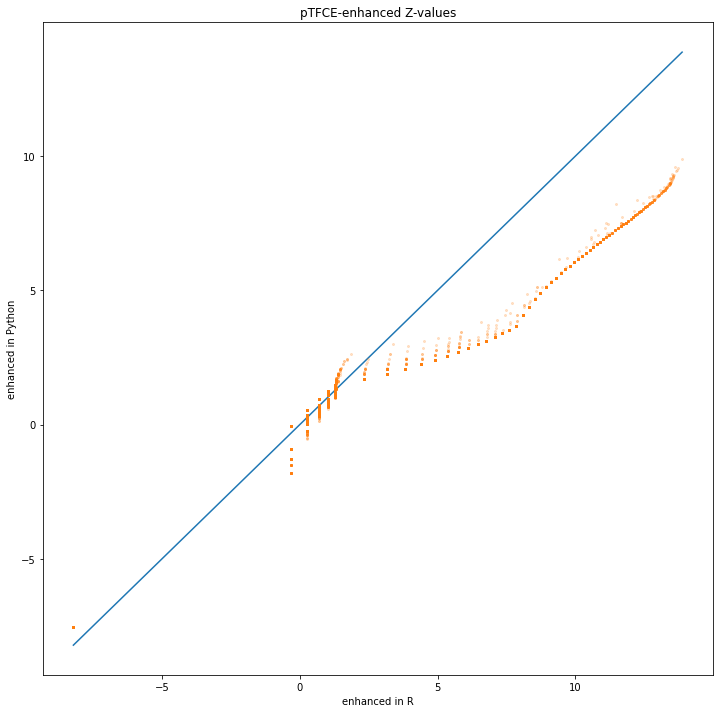

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)
# use the data range to get the y=x line
data_range = (min(arr.min() for arr in [enhanced_img, enhanced_img_R]),
              max(arr.max() for arr in [enhanced_img, enhanced_img_R]))

ax.plot(data_range, data_range)
# now scatterplot the data values
ax.plot(enhanced_img_R.ravel(), enhanced_img.ravel(), '.', markersize=4, alpha=0.2)
_ = ax.set(xlabel='enhanced in R', ylabel='enhanced in Python', title='pTFCE-enhanced Z-values')

Hmm... still some work to be done to figure out whether the difference is errorful or not. The vertical banding around zero looks like what I'd expect, but the divergence above `z ~= 1` is a bit worrying.